### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment

In [1]:
import os
import cv2
import math
import numpy as np
from tqdm import tqdm
import threading
global THREAD_NUM 
THREAD_NUM = 16

Question 1

In [5]:
def ssd_(st,end,imgL,imgR,window_size):
    width, height = imgL.shape[:2]

    for i in range(st,end):
      for j in range(window_size//2, height-window_size//2):
          min_ssd = float('inf')
          for k in range(16):
            if j-k < window_size//2:
              break
            ssd = np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k])**2)
  
            if ssd < min_ssd:
              min_ssd = ssd
              disparity[i,j] = k


def ssd(imgL,imgR,window_size):
  width, height = imgL.shape[:2] 
  st = window_size//2
  end = width-window_size//2
  chunk = math.ceil((end - st) / THREAD_NUM)
  thread_list = []
  for treadno in range(THREAD_NUM):
    i_end = min((st + chunk * (treadno+1),end))
    #ssd_((st + chunk * treadno),i_end,imgL,imgR,window_size)

    t = threading.Thread(target=ssd_,args=((st + chunk * treadno),i_end,imgL,imgR,window_size))
    t.start()
    thread_list.append(t)
  for i in range(len(thread_list)):
    thread_list[i].join()

In [6]:
global disparity


# read images
imgL = cv2.imread('left.jpg', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('right.jpg', cv2.IMREAD_GRAYSCALE)
# SSD
print("SSD")

lock = threading.Lock()
width, height = imgL.shape[:2]
disparity = np.zeros((width, height), np.uint8) 


ssd(imgL,imgR,8)
cv2.imwrite('ssd.png', disparity)


SSD


True

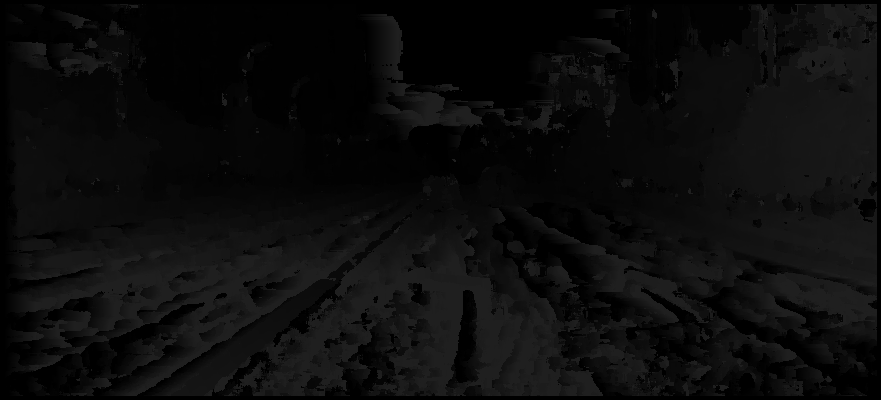

In [7]:
from google.colab.patches import cv2_imshow

cv2_imshow(disparity)

In [8]:
import cv2
import numpy as np
import math
# Anisotropic diffusion
class anisodiff(object):
 
    def __init__(self, num_iter=5, delta_t=1/7, kappa=30, option=2):
 
        super(anisodiff, self).__init__()
 
        self.num_iter = num_iter
        self.delta_t = delta_t
        self.kappa = kappa
        self.option = option
 
        self.hN = np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]])
        self.hS = np.array([[0, 0, 0], [0, -1, 0], [0, 1, 0]])
        self.hE = np.array([[0, 0, 0], [0, -1, 1], [0, 0, 0]])
        self.hW = np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]])
        self.hNE = np.array([[0, 0, 1], [0, -1, 0], [0, 0, 0]])
        self.hSE = np.array([[0, 0, 0], [0, -1, 0], [0, 0, 1]])
        self.hSW = np.array([[0, 0, 0], [0, -1, 0], [1, 0, 0]])
        self.hNW = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]])
 
    def fit(self, img):
 
        diff_im = img.copy()
 
        dx = 1; dy = 1; dd = math.sqrt(2)
 
        for i in range(self.num_iter):
            nablaN = cv2.filter2D(diff_im, -1, self.hN)
            nablaS = cv2.filter2D(diff_im, -1, self.hS)
            nablaW = cv2.filter2D(diff_im, -1, self.hW)
            nablaE = cv2.filter2D(diff_im, -1, self.hE)
            nablaNE = cv2.filter2D(diff_im, -1, self.hNE)
            nablaSE = cv2.filter2D(diff_im, -1, self.hSE)
            nablaSW = cv2.filter2D(diff_im, -1, self.hSW)
            nablaNW = cv2.filter2D(diff_im, -1, self.hNW)
 
            cN = 0; cS = 0; cW = 0; cE = 0; cNE = 0; cSE = 0; cSW = 0; cNW = 0
 
            if self.option == 1:
                cN = np.exp(-(nablaN/self.kappa)**2)
                cS = np.exp(-(nablaS/self.kappa)**2)
                cW = np.exp(-(nablaW/self.kappa)**2)
                cE = np.exp(-(nablaE/self.kappa)**2)
                cNE = np.exp(-(nablaNE/self.kappa)**2)
                cSE = np.exp(-(nablaSE/self.kappa)**2)
                cSW = np.exp(-(nablaSW/self.kappa)**2)
                cNW = np.exp(-(nablaNW/self.kappa)**2)
            elif self.option == 2:
                cN = 1/(1+(nablaN/self.kappa)**2)
                cS = 1/(1+(nablaS/self.kappa)**2)
                cW = 1/(1+(nablaW/self.kappa)**2)
                cE = 1/(1+(nablaE/self.kappa)**2)
                cNE = 1/(1+(nablaNE/self.kappa)**2)
                cSE = 1/(1+(nablaSE/self.kappa)**2)
                cSW = 1/(1+(nablaSW/self.kappa)**2)
                cNW = 1/(1+(nablaNW/self.kappa)**2)
 
            diff_im = diff_im + self.delta_t * (
 
                (1/dy**2)*cN*nablaN +
                (1/dy**2)*cS*nablaS +
                (1/dx**2)*cW*nablaW +
                (1/dx**2)*cE*nablaE +
 
                (1/dd**2)*cNE*nablaNE +
                (1/dd**2)*cSE*nablaSE +
                (1/dd**2)*cSW*nablaSW +
                (1/dd**2)*cNW*nablaNW
            )
 
        return diff_im

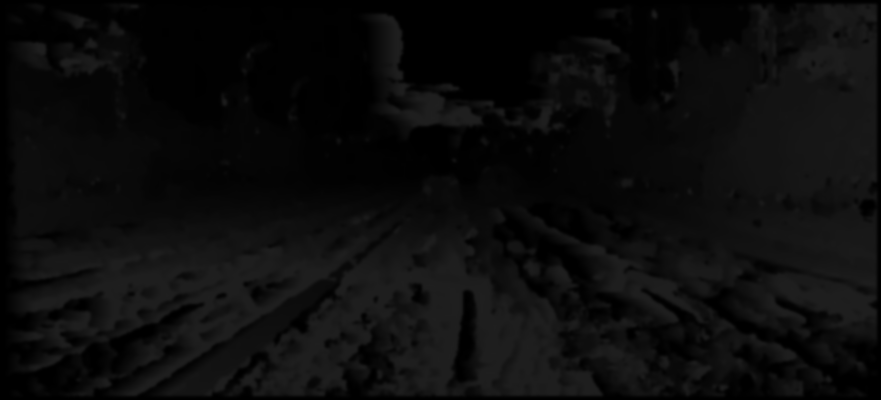

In [9]:
disparity = anisodiff().fit(disparity)
cv2_imshow(disparity)  


# Question 2

In [ ]:
img_truth = cv2.imread('truth.png', -1)
disparity = cv2.imread('ssd.png', cv2.IMREAD_GRAYSCALE)
#disparity = cv2.GaussianBlur(disparity,(15,15),1.5)
cv2_imshow(disparity)

In [11]:
# rms = np.sqrt(np.mean(y**2))


img_truth = cv2.imread('/content/2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png', cv2.IMREAD_GRAYSCALE)
img_truth = img_truth / 256

avliable_pixels = np.where(img_truth != 0)

errors = np.abs(img_truth[avliable_pixels]-disparity[avliable_pixels])

rms = np.sqrt(np.mean( errors **2))


errors4 = np.where(errors < 4)[0]
errors2 = np.where(errors < 2)[0]
errors1 = np.where(errors < 1)[0]
errors0_5 = np.where(errors< 0.5)[0]
errors0_25 = np.where(errors < 0.25)[0]





print(errors4.shape[0]/avliable_pixels[0].shape[0] 
,errors2.shape[0]/avliable_pixels[0].shape[0]   
,errors1.shape[0]/avliable_pixels[0].shape[0]   
,errors0_5.shape[0]/avliable_pixels[0].shape[0]  
,errors0_25.shape[0]/avliable_pixels[0].shape[0]  )

rms


0.07800428819385359 0.05070959398291529 0.03487277223791535 0.026670750660812943 0.01967123847122486


18.159461831280506